In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from efficientnet_pytorch import EfficientNet
from PIL import Image
import os
from tqdm import tqdm  # Import tqdm for progress bar

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset Class
class EyeDiseaseDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = ["cataract", "glaucoma", "diabetic_retinopathy", "normal"]
        self.image_paths = []
        self.labels = []

        for idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(data_dir, class_name)
            for img_name in os.listdir(class_dir):
                self.image_paths.append(os.path.join(class_dir, img_name))
                self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset
data_dir = "DATASET"  
dataset = EyeDiseaseDataset(data_dir, transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Load EfficientNet model
model = EfficientNet.from_pretrained("efficientnet-b0", num_classes=4)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Wrap the train_loader with tqdm for a progress bar
    train_loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)
    for images, labels in train_loop:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        running_loss += loss.item()

        # Update progress bar description
        train_loop.set_postfix(loss=loss.item(), accuracy=(100 * correct / total))

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

print("Training complete!")

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'DATASET\\cataract'

In [12]:
!pip install -r app\requirement.txt

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 1.6/1.6 MB 27.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/204.1 MB ? eta -:--:--
   --- ------------------------------------ 16.0/204.1 MB 77.5 MB/s eta 0:00:03
   ----- ---------------------------------- 29.6/204.1 MB 69.6 MB/s eta 0:00:03
   ------- -------------------------------- 38.5/204.1 MB 61.2 MB/s eta 0:00:03
   ---------- ----------------------------- 52.4/204.1 MB 60.7 MB/s eta 0:00:03
   ------------- -------------------------- 66.6/204.1 MB 62.5 MB/s eta 0:00:03
   --------------- ------------------------ 80.2/204.1 MB 62.4 MB/s eta 0:00:02
   ------------------ --------------------- 94.9/204.1 MB 63.8 MB/s eta 0:00:02
   ----------------

In [6]:
torch.save(model.state_dict(), "trained_model.pth")

In [8]:
import torch
from torchvision import transforms
from efficientnet_pytorch import EfficientNet
from PIL import Image
import os

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the class names
class_names = ["cataract", "glaucoma", "diabetic_retinopathy", "normal"]

# Load the trained model
def load_model(model_path, num_classes=4):
    model = EfficientNet.from_pretrained("efficientnet-b0", num_classes=num_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()  # Set the model to evaluation mode
    return model

# Define transformations for the input image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to predict the class of an image
def predict_image(image_path, model):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(device)

    # Perform prediction
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        predicted_class = class_names[predicted.item()]

    return predicted_class

# Main function to run predictions
def main():
    # Path to the trained model
    model_path = "trained_model.pth"  # Replace with your model path

    # Load the model
    model = load_model(model_path)

    # Path to the image you want to predict
    image_path = "download.jpg"  # Replace with your test image path

    # Check if the image exists
    if not os.path.exists(image_path):
        print(f"Error: Image not found at {image_path}")
        return

    # Predict the disease
    predicted_class = predict_image(image_path, model)
    print(f"Predicted Disease: {predicted_class}")

# Run the prediction
if __name__ == "__main__":
    main()

Loaded pretrained weights for efficientnet-b0
Predicted Disease: glaucoma


Loaded pretrained weights for efficientnet-b0


Epoch [1/10], Loss: 0.4233, Accuracy: 84.03%


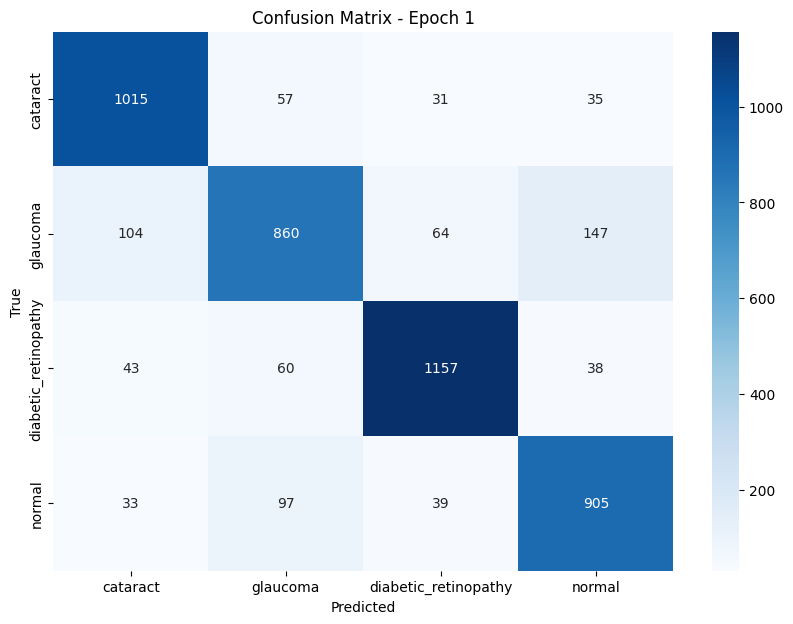

Classification Report:
                      precision    recall  f1-score   support

            cataract       0.85      0.89      0.87      1138
            glaucoma       0.80      0.73      0.76      1175
diabetic_retinopathy       0.90      0.89      0.89      1298
              normal       0.80      0.84      0.82      1074

            accuracy                           0.84      4685
           macro avg       0.84      0.84      0.84      4685
        weighted avg       0.84      0.84      0.84      4685

Accuracy: 0.8403, Recall: 0.8403, F1-Score: 0.8395


Epoch [2/10], Loss: 0.2451, Accuracy: 90.67%


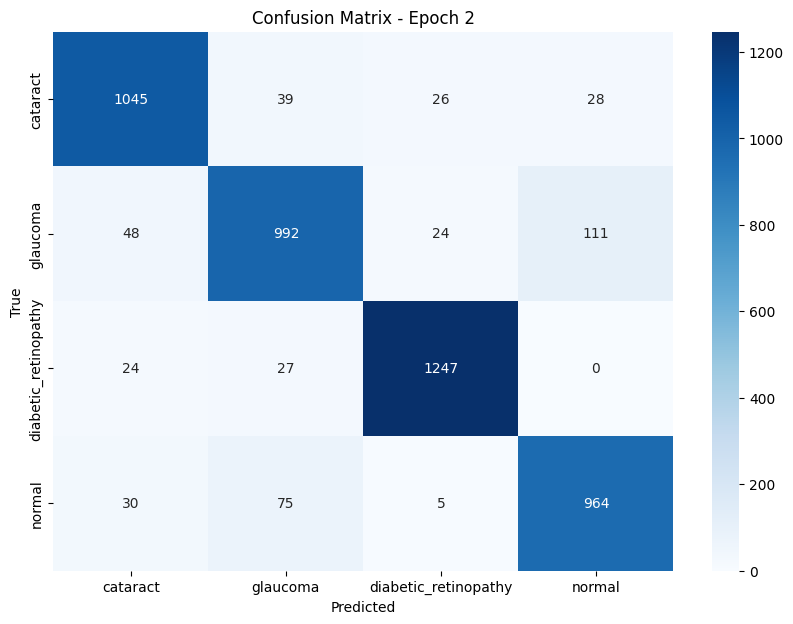

Classification Report:
                      precision    recall  f1-score   support

            cataract       0.91      0.92      0.91      1138
            glaucoma       0.88      0.84      0.86      1175
diabetic_retinopathy       0.96      0.96      0.96      1298
              normal       0.87      0.90      0.89      1074

            accuracy                           0.91      4685
           macro avg       0.90      0.91      0.90      4685
        weighted avg       0.91      0.91      0.91      4685

Accuracy: 0.9067, Recall: 0.9067, F1-Score: 0.9065


Epoch [3/10], Loss: 0.1773, Accuracy: 93.53%


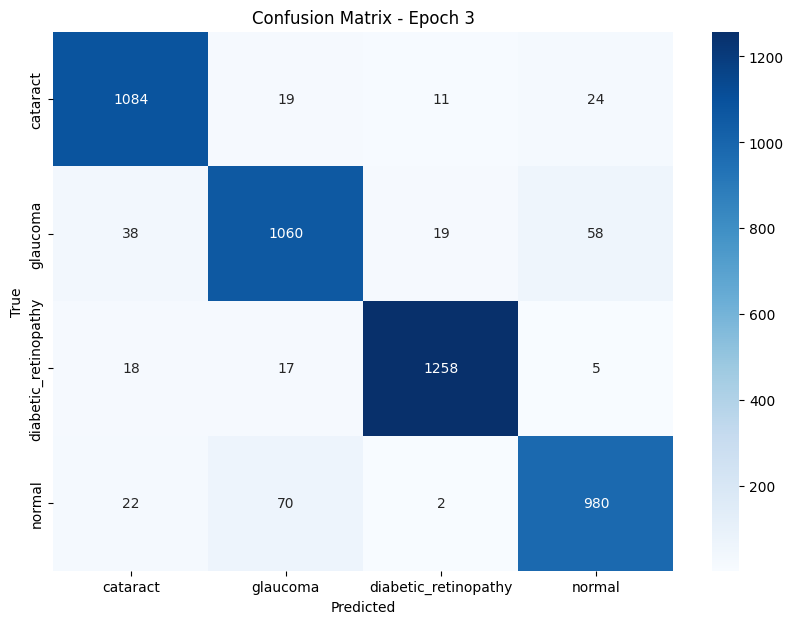

Classification Report:
                      precision    recall  f1-score   support

            cataract       0.93      0.95      0.94      1138
            glaucoma       0.91      0.90      0.91      1175
diabetic_retinopathy       0.98      0.97      0.97      1298
              normal       0.92      0.91      0.92      1074

            accuracy                           0.94      4685
           macro avg       0.93      0.93      0.93      4685
        weighted avg       0.94      0.94      0.94      4685

Accuracy: 0.9353, Recall: 0.9353, F1-Score: 0.9353


Epoch [4/10], Loss: 0.1234, Accuracy: 95.43%


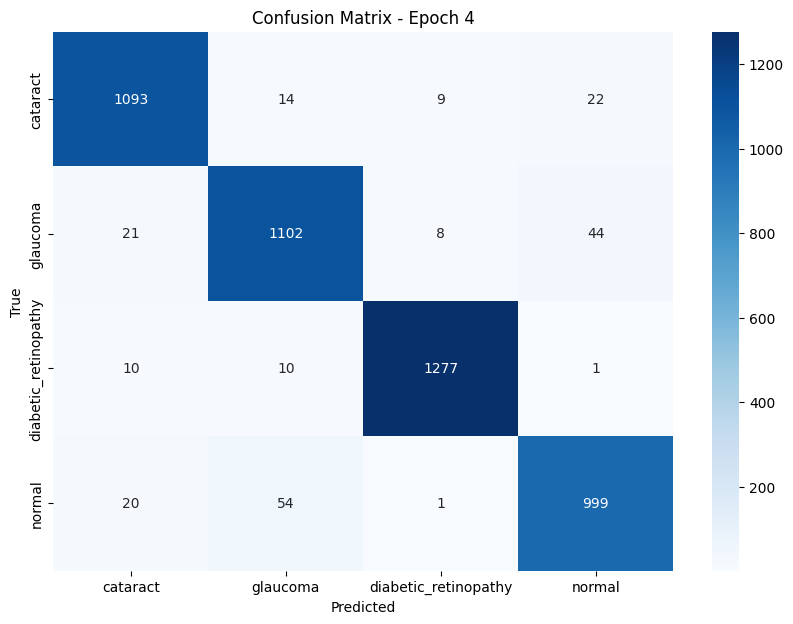

Classification Report:
                      precision    recall  f1-score   support

            cataract       0.96      0.96      0.96      1138
            glaucoma       0.93      0.94      0.94      1175
diabetic_retinopathy       0.99      0.98      0.98      1298
              normal       0.94      0.93      0.93      1074

            accuracy                           0.95      4685
           macro avg       0.95      0.95      0.95      4685
        weighted avg       0.95      0.95      0.95      4685

Accuracy: 0.9543, Recall: 0.9543, F1-Score: 0.9543


Epoch [5/10], Loss: 0.0997, Accuracy: 96.52%


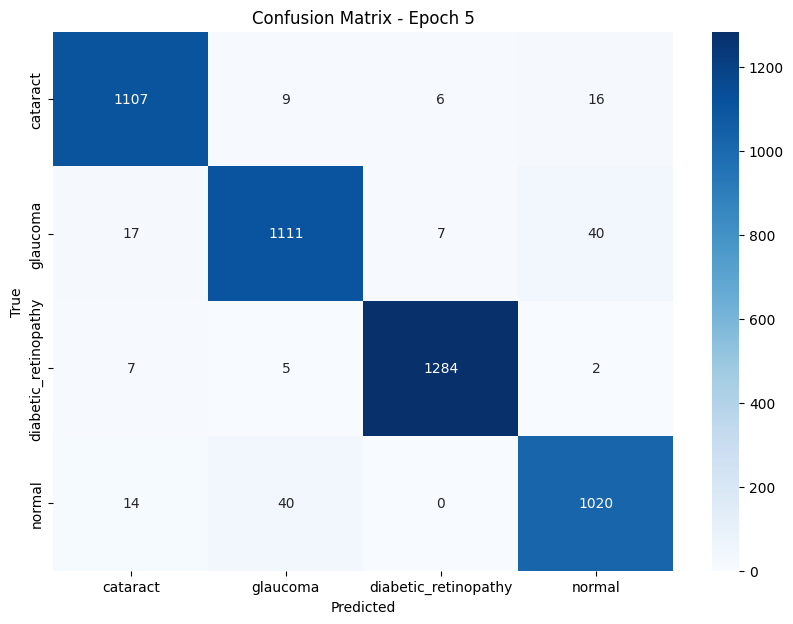

Classification Report:
                      precision    recall  f1-score   support

            cataract       0.97      0.97      0.97      1138
            glaucoma       0.95      0.95      0.95      1175
diabetic_retinopathy       0.99      0.99      0.99      1298
              normal       0.95      0.95      0.95      1074

            accuracy                           0.97      4685
           macro avg       0.96      0.96      0.96      4685
        weighted avg       0.97      0.97      0.97      4685

Accuracy: 0.9652, Recall: 0.9652, F1-Score: 0.9652


Epoch [6/10], Loss: 0.0915, Accuracy: 96.73%


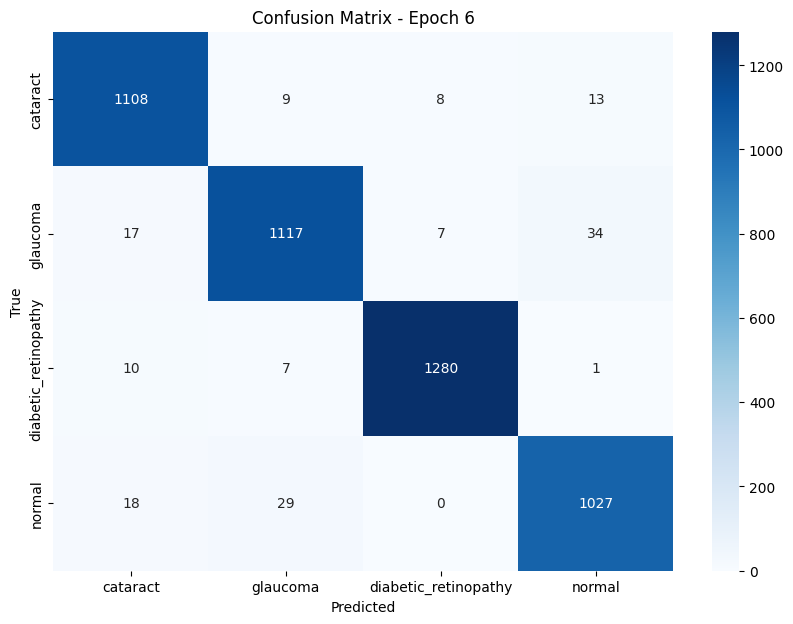

Classification Report:
                      precision    recall  f1-score   support

            cataract       0.96      0.97      0.97      1138
            glaucoma       0.96      0.95      0.96      1175
diabetic_retinopathy       0.99      0.99      0.99      1298
              normal       0.96      0.96      0.96      1074

            accuracy                           0.97      4685
           macro avg       0.97      0.97      0.97      4685
        weighted avg       0.97      0.97      0.97      4685

Accuracy: 0.9673, Recall: 0.9673, F1-Score: 0.9673


Epoch [7/10], Loss: 0.0621, Accuracy: 97.87%


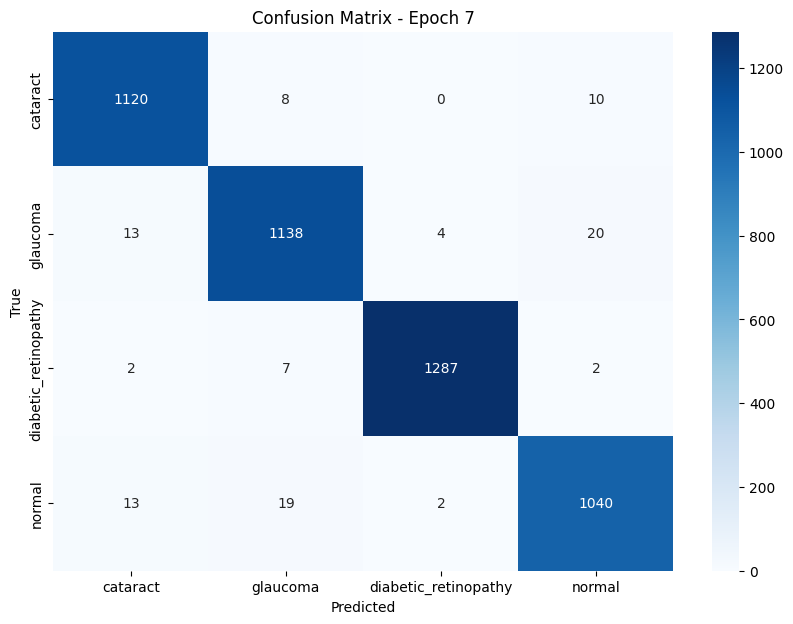

Classification Report:
                      precision    recall  f1-score   support

            cataract       0.98      0.98      0.98      1138
            glaucoma       0.97      0.97      0.97      1175
diabetic_retinopathy       1.00      0.99      0.99      1298
              normal       0.97      0.97      0.97      1074

            accuracy                           0.98      4685
           macro avg       0.98      0.98      0.98      4685
        weighted avg       0.98      0.98      0.98      4685

Accuracy: 0.9787, Recall: 0.9787, F1-Score: 0.9787


Epoch [8/10], Loss: 0.0859, Accuracy: 97.12%


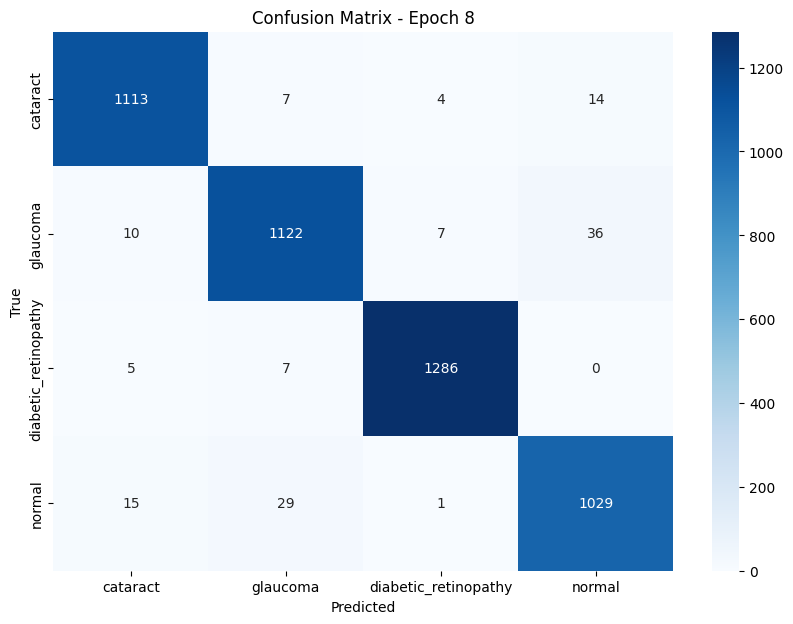

Classification Report:
                      precision    recall  f1-score   support

            cataract       0.97      0.98      0.98      1138
            glaucoma       0.96      0.95      0.96      1175
diabetic_retinopathy       0.99      0.99      0.99      1298
              normal       0.95      0.96      0.96      1074

            accuracy                           0.97      4685
           macro avg       0.97      0.97      0.97      4685
        weighted avg       0.97      0.97      0.97      4685

Accuracy: 0.9712, Recall: 0.9712, F1-Score: 0.9712


Epoch [9/10], Loss: 0.0626, Accuracy: 98.01%


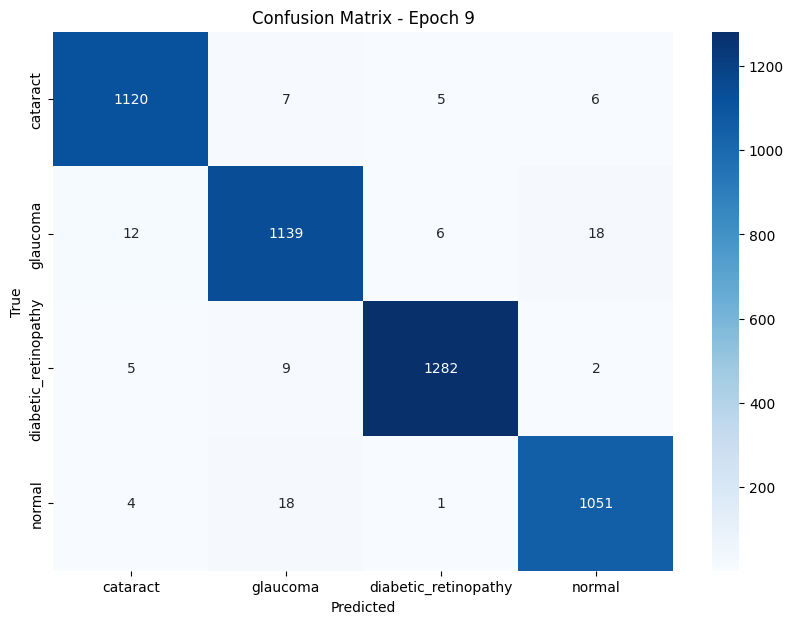

Classification Report:
                      precision    recall  f1-score   support

            cataract       0.98      0.98      0.98      1138
            glaucoma       0.97      0.97      0.97      1175
diabetic_retinopathy       0.99      0.99      0.99      1298
              normal       0.98      0.98      0.98      1074

            accuracy                           0.98      4685
           macro avg       0.98      0.98      0.98      4685
        weighted avg       0.98      0.98      0.98      4685

Accuracy: 0.9801, Recall: 0.9801, F1-Score: 0.9802


Epoch [10/10], Loss: 0.0481, Accuracy: 98.36%


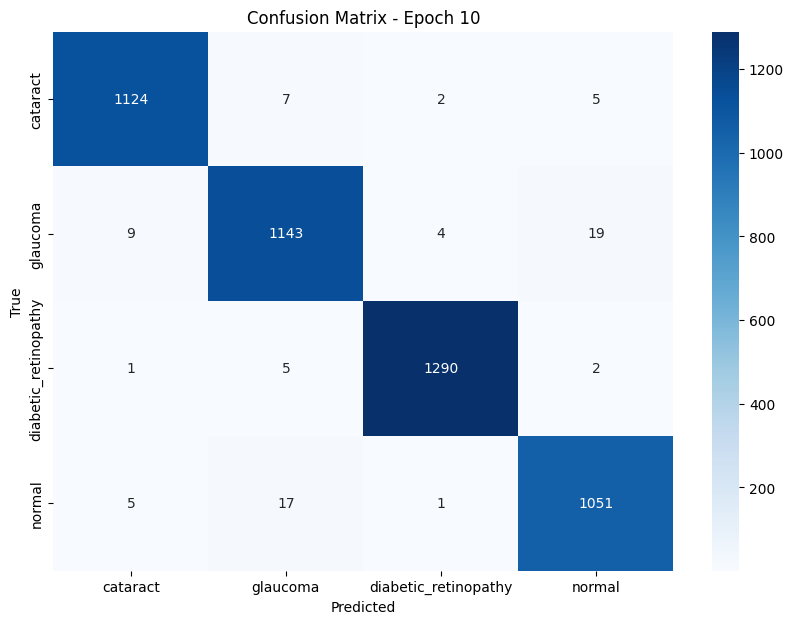

Classification Report:
                      precision    recall  f1-score   support

            cataract       0.99      0.99      0.99      1138
            glaucoma       0.98      0.97      0.97      1175
diabetic_retinopathy       0.99      0.99      0.99      1298
              normal       0.98      0.98      0.98      1074

            accuracy                           0.98      4685
           macro avg       0.98      0.98      0.98      4685
        weighted avg       0.98      0.98      0.98      4685

Accuracy: 0.9836, Recall: 0.9836, F1-Score: 0.9836


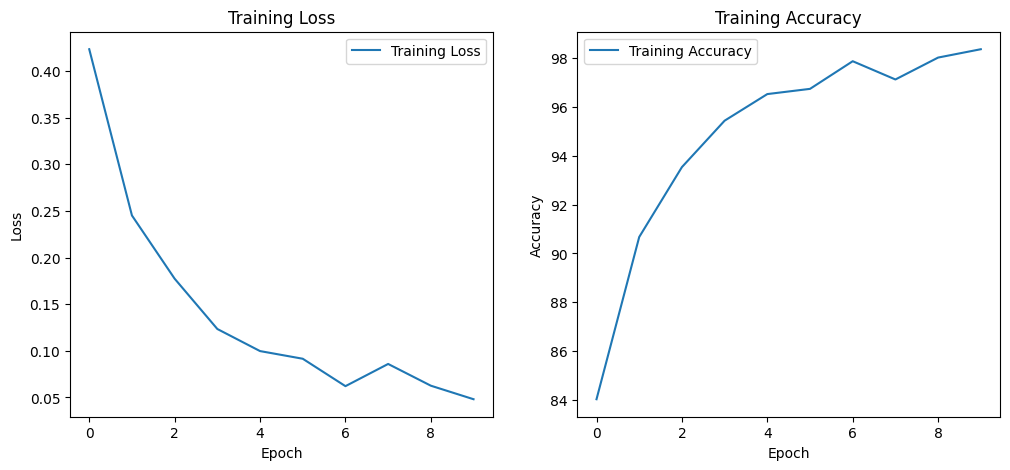

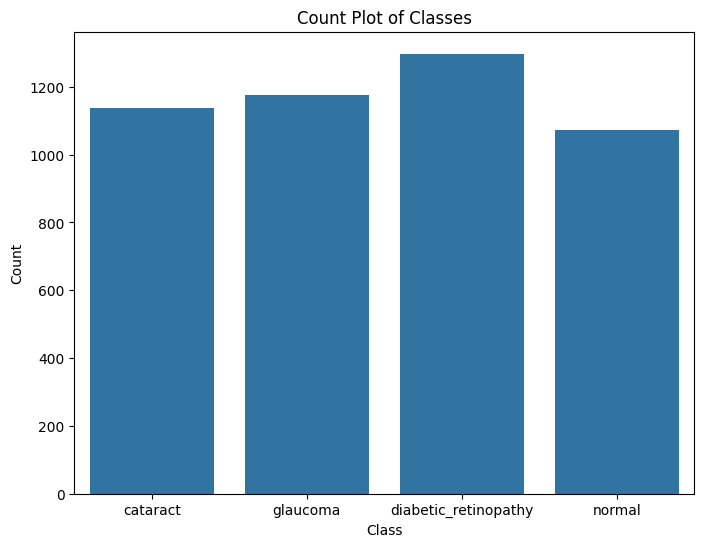

Training complete!


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from efficientnet_pytorch import EfficientNet
from PIL import Image
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, f1_score

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset Class
class EyeDiseaseDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = ["cataract", "glaucoma", "diabetic_retinopathy", "normal"]
        self.image_paths = []
        self.labels = []

        for idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(data_dir, class_name)
            for img_name in os.listdir(class_dir):
                self.image_paths.append(os.path.join(class_dir, img_name))
                self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset
data_dir = "DATASET" 
dataset = EyeDiseaseDataset(data_dir, transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Load EfficientNet model
model = EfficientNet.from_pretrained("efficientnet-b0", num_classes=4)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store metrics for plotting
train_losses = []
train_accuracies = []

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    # Wrap the train_loader with tqdm for a progress bar
    train_loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)
    for images, labels in train_loop:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        running_loss += loss.item()

        # Store labels and predictions for confusion matrix
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

        # Update progress bar description
        train_loop.set_postfix(loss=loss.item(), accuracy=(100 * correct / total))

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - Epoch {epoch+1}')
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=dataset.classes))

    # Accuracy, Recall, F1-Score
    accuracy = accuracy_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f"Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

# Plotting the training loss and accuracy
plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.show()

# Count Plot
plt.figure(figsize=(8, 6))
sns.countplot(x=all_labels)
plt.xticks(ticks=np.arange(len(dataset.classes)), labels=dataset.classes)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Count Plot of Classes')
plt.show()

print("Training complete!")



